In [89]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
import Augmentor
import os
import shutil

In [90]:
def unpickle_data(filename):
    with open(filename, mode='rb') as f:
        file = pickle.load(f)
    return file['features'], file['labels']

def pickle_data(X, y, filename):
    data = {
        "features":X,
        "labels":y
    }
    with open(filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [91]:
# Import original data
X_train, y_train = unpickle_data("Data/Original/train.p")

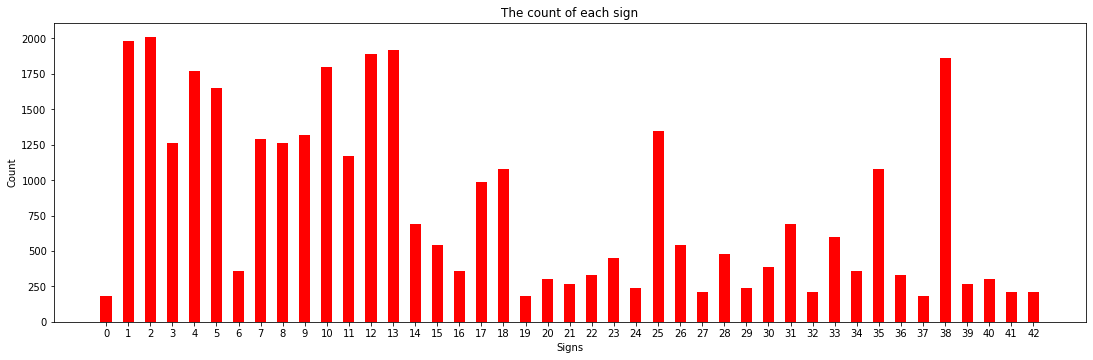

In [92]:
def plot_class_freq(y):
    counts = np.bincount(y)
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 5.5)
    ax.bar(range(len(counts)), counts, 0.5, color='r')
    ax.set_xlabel('Signs')
    ax.set_xticks(np.arange(len(counts)))
    ax.set_ylabel('Count')
    ax.set_title('The count of each sign')
    plt.show()

plot_class_freq(y_train)

# Manual data manipulation

In [93]:
def horizontal_flip(X):
    return X[:,:,::-1,:]

def vertical_flip(X):
    return X[:,::-1,:,:]

def both_flip(X):
    return X[:,::-1,::-1,:]

def extend_dataset(X, y, fnc, a, b):
    indexes = np.where(y == a)[0]
    X_ = fnc(X[indexes])
    y_ = np.full(len(indexes), b)
    return X_, y_

horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
vertically_flippable = [1, 5, 12, 15, 17]
both_flippable = [17, 32, 40]
cross_flippable = np.array([
    [19, 20],
    [33, 34],
    [36, 37],
    [38, 39]
])

In [94]:
X_copy, y_copy = X_train.copy(), y_train.copy()
for i in horizontally_flippable:
    X, y = extend_dataset(X_copy, y_copy, horizontal_flip,i,i)
    X_train, y_train = np.concatenate((X_train, X), axis=0), np.concatenate((y_train, y), axis=0)

for i in vertically_flippable:
    X, y = extend_dataset(X_copy, y_copy, vertical_flip,i,i)
    X_train, y_train = np.concatenate((X_train, X), axis=0), np.concatenate((y_train, y), axis=0) 
    
for i in both_flippable:
    X, y = extend_dataset(X_copy, y_copy, both_flip,i,i)
    X_train, y_train = np.concatenate((X_train, X), axis=0), np.concatenate((y_train, y), axis=0)    

for i,j in cross_flippable:
    X, y = extend_dataset(X_copy, y_copy,horizontal_flip,i,j)
    X_train, y_train = np.concatenate((X_train, X), axis=0), np.concatenate((y_train, y), axis=0)
    X, y = extend_dataset(X_copy, y_copy,horizontal_flip,j,i)
    X_train, y_train = np.concatenate((X_train, X), axis=0), np.concatenate((y_train, y), axis=0)

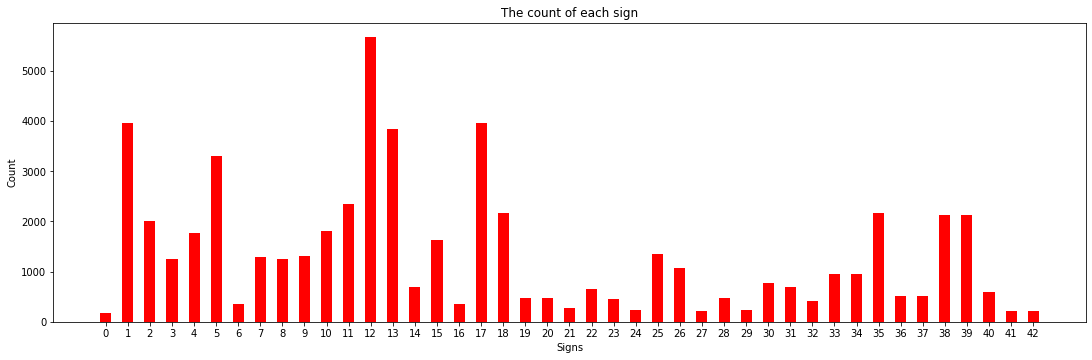

In [95]:
plot_class_freq(y_train)

# Automatic data manipulation

In [96]:
def save_images(root_path, X, y):
    for i,array in enumerate(X):
        folder_path = root_path + "/class-" + str(y[i])
        if not os.path.isdir(folder_path):
            os.makedirs(folder_path)
        im_name = folder_path + "/P" + str(i) + ".png"
        im = Image.fromarray(array)
        im.save(im_name)
        
def load_images(root_path):
    X = []
    y = []
    class_paths = [x[0] for x in os.walk(root_path)][1:]
    for path in class_paths:
        image_paths = [x[2] for x in os.walk(path)][0]
        label = int(path.split("class-")[1])
        for image_path in image_paths:
            img = np.asarray(Image.open(path+'/'+image_path))
            X.append(img)
            y.append(label)
    return np.array(X),np.array(y)

In [97]:
def augment_dataset(X, y, root_name, n_samples_per_class = 2000):
    output_width, output_height = 32, 32    

    number_of_classes = np.bincount(y_train)

    for label in range(43): 
        n_original = number_of_classes[label]
        directory = root_name+"/class-" + str(label)
        if n_original>n_samples_per_class:
            continue
        p = Augmentor.Pipeline(directory, output_directory=directory)
        p.skew(probability=0.2)
        p.rotate(probability=0.2, max_left_rotation=10, max_right_rotation=10)
        p.random_distortion(probability = 0.2, grid_width = int(output_width * 0.9) , grid_height = int(output_height * 0.9), magnitude = 1)
        p.random_brightness(probability = 0.2, min_factor = 0.8, max_factor = 1.6)
        p.random_contrast(probability = 0.2, min_factor = 0.8, max_factor = 1.0)
        p.random_erasing(probability= 0.1, rectangle_area = 0.2)
        p.sample(n_samples_per_class - n_original)

In [ ]:
root_name = os.getcwd()+"/original-train-images"

# We have to save the images to a folder because the augment library needs to have
# the images saved in a file to be able to work with them

save_images(root_name, X_train, y_train)
augment_dataset(X_train, y_train, root_name)

# After the augmentation is complete load the images into numpy so we can save them 
# in pickle format which is the native format we used for loading images in this project.
X_extended_train, y_extended_train = load_images(root_name)
shutil.rmtree(root_name)

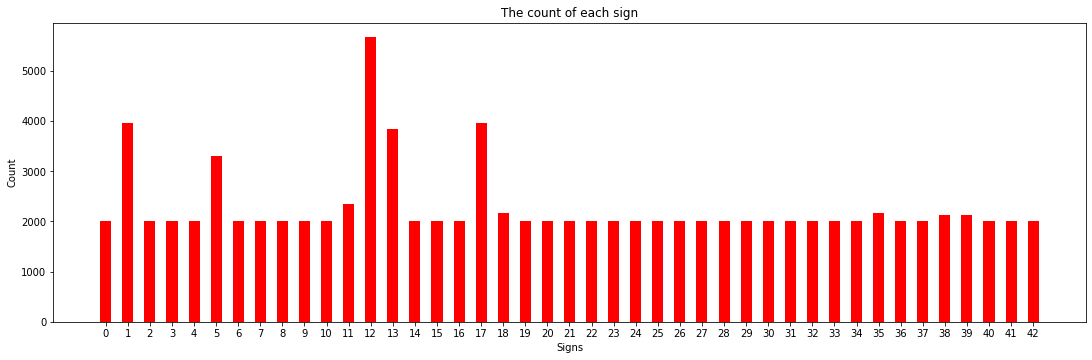

In [99]:
plot_class_freq(y_extended_train)

# Contrast Limited Adaptive Histogram Equalization

In [100]:
import cv2

In [101]:
def improve_contrast_image_using_clahe(img: np.array) -> np.array:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_planes = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(3, 3))
    hsv_planes[2] = clahe.apply(hsv_planes[2])
    img = cv2.merge(hsv_planes)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return img

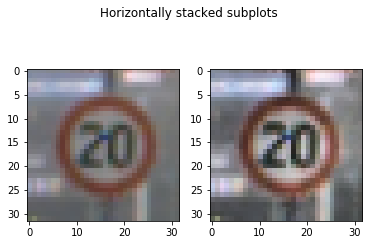

In [115]:
example = 10000
fig, ax = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax[0].imshow(X_train[example])
ax[1].imshow(improve_contrast_image_using_clahe(X_train[example]))

In [103]:
def apply_clahe(X):
    X_final = []
    for image in X:
        X_final.append(improve_contrast_image_using_clahe(image))
    return np.array(X_final)

In [104]:
X_final_train = apply_clahe(X_extended_train)
pickle_data(X_final_train, y_extended_train, "Data/Preprocessed/train.p")

In [105]:
X_valid, y_valid = unpickle_data("Data/Original/valid.p")
X_final_valid = apply_clahe(X_valid)
pickle_data(X_final_valid, y_valid, "Data/Preprocessed/valid.p")

In [106]:
X_test, y_test = unpickle_data("Data/Original/test.p")
X_final_test = apply_clahe(X_test)
pickle_data(X_final_test, y_test, "Data/Preprocessed/test.p")